In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.style.use('seaborn-notebook')

In [2]:
def make_random(size, c, a):
    return c + 2*a*np.random.random(size) - a

In [40]:
def make_dataset(N, M):
    X1 = np.linspace(-3, 5, N)
    X2 = np.linspace(-3, 5, N)
    Y1 = 2*X1 - 3
    Y2 = -3*X2 - 2
    Y1 += make_random(N, 0, 1.0)
    Y2 += make_random(N, 0, 1.0)
    X3 = np.hstack((make_random(M, -2, 1), 
                    make_random(M, 4.5, 1), 
                    make_random(M, -2., 1), 
                    make_random(M, 4.5, 1))) 
    Y3 = np.hstack((make_random(M, 15, 3), 
                    make_random(M, 17., 3), 
                    make_random(M, -20., 3), 
                    make_random(M, -25., 3))) 
    X = np.hstack((X1, X2))
    Y = np.hstack((Y1, Y2))
    X_o = np.hstack((X1, X2, X3))
    Y_o = np.hstack((Y1, Y2, Y3))
    return X, Y, X_o, Y_o

X, Y, X_o, Y_o = make_dataset(44, 20)
Xs = X.reshape(-1,1)
Xs_o = X_o.reshape(-1,1)
x_min, x_max = X_o.min()-0.5, X_o.max()+0.5
y_min, y_max = Y_o.min()-1, Y_o.max()+1
print(2*44/(2*44 + 4*20))

0.5238095238095238


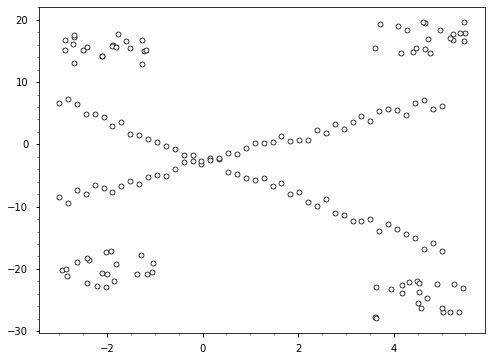

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(X_o, Y_o, s=25, c='w', edgecolors='k', linewidth=0.75)
plt.minorticks_on()
plt.show()

In [42]:
import mlgrad
import mlgrad.model as ml_model
import mlgrad.risk as ml_risk
import mlgrad.loss as ml_loss
import mlgrad.weights as ml_weights
import mlgrad.func as ml_func
import mlgrad.af as ml_af

In [43]:
# minloss = ml_loss.SoftMinLoss(ml_loss.ErrorLoss(ml_func.Square()), 2, a=14)
minloss = ml_loss.SoftMinLoss(ml_loss.ErrorLoss(ml_func.SoftAbs(0.001)), 2, a=14)

In [44]:
def create_model():
    layer = ml_model.GeneralModelLayer(1)
    linmod1 = ml_model.LinearModel(1)
    linmod2 = ml_model.LinearModel(1)
    layer.append(linmod1)
    layer.append(linmod2)
    nn = ml_model.FFNetworkModel()
    nn.add(layer)

    nn.allocate()
    nn.init_param()
    return nn, linmod1, linmod2

In [45]:
nn, linmod1, linmod2 = create_model()
nn_o, linmod1_o, linmod2_o = create_model()

In [46]:
risk = ml_risk.ER21(Xs, Y, nn, minloss)
risk_o = ml_risk.ER21(Xs_o, Y_o, nn_o, minloss)

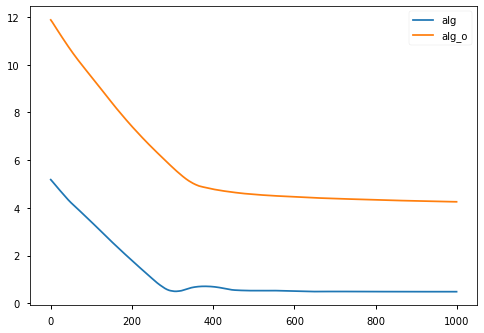

In [47]:
alg = mlgrad.erm_fg(risk, n_restart=1, h=0.01, tol=1.0e-9)
alg_o = mlgrad.erm_fg(risk_o, n_restart=1, h=0.01, tol=1.0e-9)

plt.plot(alg.lvals, label='alg')
plt.plot(alg_o.lvals, label='alg_o')
plt.legend()
plt.show()

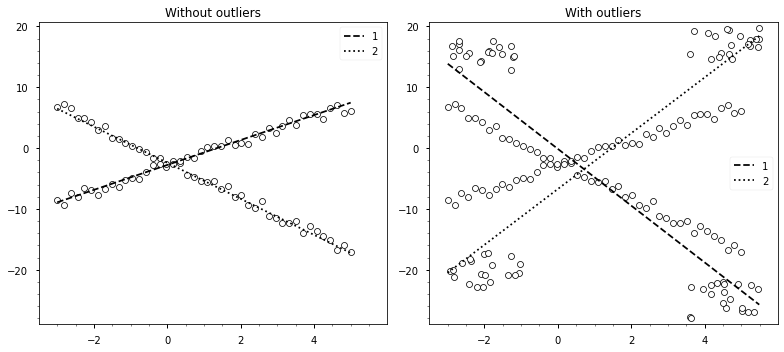

In [48]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.title('Without outliers')
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidth=0.75)
XX = np.array([X.min(), X.max()])
XXs = XX.reshape(-1,1)
plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.minorticks_on()
plt.subplot(1,2,2)
plt.title('With outliers')
plt.scatter(X_o, Y_o, s=36, c='w', edgecolors='k', linewidth=0.75)
XX_o = np.array([X_o.min(), X_o.max()])
XXs_o = XX_o.reshape(-1,1)
plt.plot(XX_o, linmod1_o.evaluate_all(XXs_o), linestyle='--', label='1', color='k')
plt.plot(XX_o, linmod2_o.evaluate_all(XXs_o), linestyle=':', label='2', color='k')
plt.minorticks_on()
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

In [49]:
rob_nn_o, rob_linmod1_o, rob_linmod2_o = create_model()

In [50]:
rob_risk = ml_risk.ER21(X.reshape(-1,1), Y, rob_nn_o, minloss)
agg_func = ml_af.averaging_function("WM", alpha=0.53, rhofunc=ml_func.Sqrt(0.001))
weights = ml_weights.MWeights(agg_func, rob_risk)

3.456649921477371
0.22439712435647777


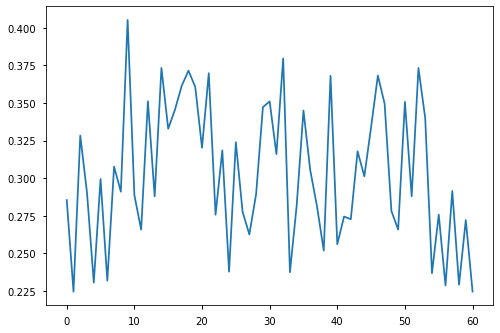

In [51]:
rob_fg = mlgrad.fg(rob_risk, h=0.01, tol=1.0e-9)
rob_alg = mlgrad.erm_irgd(rob_fg, weights)

plt.plot(rob_alg.lvals)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


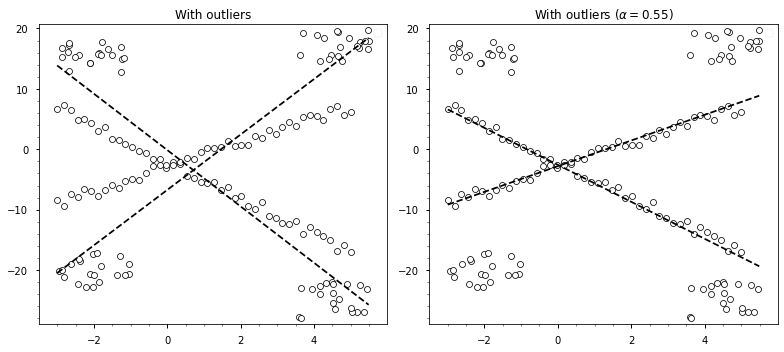

In [55]:
plt.figure(figsize=(11,5))
# plt.subplot(1,3,1)
# plt.title('Without outliers')
# plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidth=0.75)
# XX = np.array([X.min(), X.max()])
# XXs = XX.reshape(-1,1)
# plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
# plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.legend()
# plt.minorticks_on()
plt.subplot(1,2,1)
plt.title('With outliers')
plt.scatter(X_o, Y_o, s=36, c='w', edgecolors='k', linewidth=0.75)
XX_o = np.array([X_o.min(), X_o.max()])
XXs_o = XX_o.reshape(-1,1)
plt.plot(XX_o, linmod1_o.evaluate_all(XXs_o), linestyle='--', color='k')
plt.plot(XX_o, linmod2_o.evaluate_all(XXs_o), linestyle='--', color='k')
plt.minorticks_on()
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.subplot(1,2,2)
plt.title(r'With outliers $(\alpha=0.55)$')
plt.scatter(X_o, Y_o, s=36, c='w', edgecolors='k', linewidth=0.75)
XX_o = np.array([X_o.min(), X_o.max()])
XXs_o = XX_o.reshape(-1,1)
plt.plot(XX_o, rob_linmod1_o.evaluate_all(XXs_o), linestyle='--', color='k')
plt.plot(XX_o, rob_linmod2_o.evaluate_all(XXs_o), linestyle='--', color='k')
plt.minorticks_on()
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('robust_kmeans_regression_test_1.eps')
plt.show()